In [2]:
# Setting .env
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("HF_TOKEN")

### What we're going to build

We're going to be bulding a `food`/`not_food` **text classification model**. 

Given a piece of a text (such as an image caption), our model will be able to predict if it's about food or not.

More specifically, we're going to follow the following steps:

1. **[Data](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions): Problem defintion and dataset preparation** - Getting a dataset/setting up the problem space.
2. **[Model](https://huggingface.co/mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased): Finding, training and evaluating a model** - Finding a text classification model suitable for our problem on Hugging Face and customizing it to our own dataset.
3. **[Demo](https://huggingface.co/spaces/mrdbourke/learn_hf_food_not_food_text_classifier_demo): Creating a demo and put our model into the real world** - Sharing our trained model in a way others can access and use.

By the end of this project, you'll have a trained model and [demo on Hugging Face](https://huggingface.co/spaces/mrdbourke/learn_hf_food_not_food_text_classifier_demo) you can share with others:

### Import Necessary Libraries

In [3]:
# install dependencies
try:
    import datasets, evaluate, accelerate
    import gradio as gr
except ModuleNotFoundError:
    %pip install -U datasets, evaluate, accelerate, gradio
    import datasets, evaluate, accelerate
    import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Transformers version: {transformers.__version__}")
print(f"Datasets version: {datasets.__version__}")
print(f"Torch version: {torch.__version__}")


Transformers version: 4.44.2
Datasets version: 3.0.0
Torch version: 2.4.1+cu121


## Loading a Dataset

In [4]:
# Load the dataset from hugging face hub
dataset = datasets.load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")

# inspect the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [5]:
# what features are there
dataset.column_names

{'train': ['text', 'label']}

In [6]:
# Access the training split
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [7]:
dataset['train'][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

### Inspect random examples from the dataset

In [8]:
import random

random_indexes = random.sample(range(len(dataset['train'])), 5)
random_samples  = dataset['train'][random_indexes]

print(f"[INFO] Random samples from dataset:\n")
for item in zip(random_samples['text'], random_samples['label']):
    print(f"Text: {item[0]} | Label: {item[1]}")

[INFO] Random samples from dataset:

Text: A gourmet pizza with a pesto base, topped with grilled chicken and sun-dried tomatoes | Label: food
Text: A bowl of mixed berries, including blueberries, raspberries, and blackberries | Label: food
Text: Yellow squash in a bowl, sprinkled with oregano and served with a side of pesto sauce for a tasty, flavorful dish. | Label: food
Text: A square slice of Sicilian-style pizza with a thick and fluffy crust | Label: food
Text: Hearty pumpkin curry with toasted pumpkin seeds, featuring sweet pumpkin pieces in a creamy coconut milk sauce, finished with toasted seeds. | Label: food


In [9]:
# Get unique label values
dataset['train'].unique('label')

['food', 'not_food']

In [10]:
# Check number of each label
from collections import Counter

Counter(dataset['train']['label'])

Counter({'food': 125, 'not_food': 125})

In [11]:
# Turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset['train'])
food_not_food_df

,text,label
0,"Creamy cauliflower curry with garlic naan, fea...",food
1,Set of books stacked on a desk,not_food
2,"Watching TV together, a family has their dog s...",not_food
3,Wooden dresser with a mirror reflecting the room,not_food
4,Lawn mower stored in a shed,not_food
...,...,...
245,Standing floor lamp providing light next to an...,not_food
246,Luxurious coconut shrimp curry on a generous p...,food
247,Barbecue grill waiting on a patio,not_food
248,"Family gathered around a dining table, laughin...",not_food


In [12]:
# Get the value counts of the label column
food_not_food_df['label'].value_counts()

label
food        125
not_food    125
Name: count, dtype: int64

## Preparing data for text classification

### Creating a mapping from labels to numbers

In [13]:
# Create mapping from id2label and label2id
id2label = {'0': 'not_food', '1' : 'food'}
label2id = {'not_food' : '0', 'food' : '1'}

print(id2label)
print(label2id)

{'0': 'not_food', '1': 'food'}
{'not_food': '0', 'food': '1'}


In [14]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset['train'].unique('label')[::-1])}
label2id = {label: idx for idx, label in id2label.items()}

print(f"ID to Label mapping: {id2label}")
print(f"Label to ID mapping: {label2id}")

ID to Label mapping: {0: 'not_food', 1: 'food'}
Label to ID mapping: {'not_food': 0, 'food': 1}


In [15]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
    example['label'] = label2id[example['label']]

    return example

example_sample = {"text": "I love eating chicken.", "label": "food"}

# Test the function 
map_labels_to_number(example_sample)

{'text': 'I love eating chicken.', 'label': 1}

In [16]:
# Map our dataset labels to numbers
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [17]:
# Shuffle the dataset and view the first 5 samples (will return different results each time) 
dataset.shuffle()[:5]

{'text': ['A bowl of sliced cucumbers with a sprinkle of dill and a side of sour cream',
  'Black and white checkered kitchen floor adding a classic touch',
  'A couple enjoying a movie night on the couch with their pets snuggled close',
  'Black leather couch adding elegance to a living room',
  'Remote control placed on a couch cushion'],
 'label': [1, 0, 0, 0, 0]}

### Split the dataset into training and test sets

In [18]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [19]:
random_idx_train = random.randint(0, len(dataset['train']))
random_sample_train = dataset['train'][random_idx_train]

random_idx_test = random.randint(0, len(dataset['test']))
random_sample_test = dataset['test'][random_idx_test]

print(f"[INFO] Random sample from training dataset:")
print(f"Text: {random_sample_train['text']}\nLabel: {random_sample_train['label']} ({id2label[random_sample_train['label']]})\n")
print(f"[INFO] Random sample from testing dataset:")
print(f"Text: {random_sample_test['text']}\nLabel: {random_sample_test['label']} ({id2label[random_sample_test['label']]})")

[INFO] Random sample from training dataset:
Text: Camping tent pitched in a backyard
Label: 0 (not_food)

[INFO] Random sample from testing dataset:
Text: Wooden dresser with a mirror reflecting the room
Label: 0 (not_food)


### Tokenizing text data

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast = True)

tokenizer

/home/spadmin/miniconda3/envs/tf217/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [21]:
# Test out tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [22]:
tokenizer("Machine learning")

{'input_ids': [101, 3698, 4083, 102], 'attention_mask': [1, 1, 1, 1]}

In [23]:
# Get the length of the vocabulary 
length_of_vocab = len(tokenizer.vocab)
print(f"Length of vocabulary is {length_of_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_seq = tokenizer.model_max_length
print(f"Length of max tokenizer input sequence: {max_tokenizer_input_seq}")

Length of vocabulary is 30522
Length of max tokenizer input sequence: 512


In [24]:
tokenizer.vocab['chicken']

7975

In [25]:
# Gets error because this word is not in the vocab
# tokenizer.vocab['shivaji']

when calling the tokenizer on the word, it will automatically split the word into word pieces or subwords.

In [26]:
# We can check what word pieces got broken into with tokenizer.convert_ids_to_tokens(input_ids).
tokenizer.convert_ids_to_tokens(tokenizer('shivaji').input_ids)

['[CLS]', 'shiva', '##ji', '[SEP]']

In [27]:
# Try to tokenize an emoji
tokenizer.convert_ids_to_tokens(tokenizer("🏏").input_ids)

['[CLS]', '[UNK]', '[SEP]']

Since the tokenizer.vocab is a Python dictionary, we can get a sample of the vocabulary using tokenizer.vocab.items().

In [28]:
# Get the first 5 items in the tokenizer vocab
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

In [29]:
import random
random.sample(sorted(tokenizer.vocab.items()), k=5)

[('bust', 13950),
 ('##open', 26915),
 ('memorials', 22899),
 ('mani', 23624),
 ('negotiations', 7776)]

### Making a preprocessing function to tokenize text

In [30]:
def tokenize_text(examples):
    return tokenizer(examples['text'],
                     padding=True,
                     truncation=True)

In [31]:
example_sample_2 = {'text':"I love chicken", "label":1}

tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 7975, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [32]:
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)

tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [33]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset['train'][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



## Setting up an evaluation metric

In [34]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load('accuracy')

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
    predictions, labels = predictions_and_labels

    if len(predictions.shape)>=2:
        predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels)

In [35]:
# Create example list of predictions and labels
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


## Setting up a model for training

In [36]:
# Get id and label mappings
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

id2label: {0: 'not_food', 1: 'food'}
label2id: {'not_food': 0, 'food': 1}


In [37]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels = 2,
    id2label = id2label,
    
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Try and make a prediction with the loaded model (this will error)
# model(**tokenized_dataset['train'][0])

In [39]:
# Inspect the model
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Counting the parameters of our model

In [40]:
def count_params(model):
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

# Count the parameters of the model
count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

### Create a directory for saving models

In [41]:
# Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "learn_hf_food_not_food_classifier-ditsilbert-base-uncased"

# create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased')

### Setting up training arguments with TrainingArguments

In [42]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size= 32,
    per_device_eval_batch_size= 32,
    num_train_epochs=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy='epoch',
    report_to='none',
    # push_to_hub=True,
    # hub_token="Token_here",
    hub_private_repo=False
)

[INFO] Saving model checkpoints to: models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased


In [43]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,
evaluation_s

### Setting up an instance of Trainer

In [44]:
from transformers import Trainer

# setup trainer
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics=compute_accuracy
)

### Training our text classification model

In [45]:
# Train a text classification model
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.338900,0.038924,1.000000
2,0.020300,0.005180,1.000000
3,0.003900,0.001986,1.000000
4,0.001800,0.001150,1.000000
5,0.001200,0.000824,1.000000
6,0.000900,0.000674,1.000000
7,0.000700,0.000594,1.000000
8,0.000700,0.000551,1.000000
9,0.000600,0.000528,1.000000
10,0.000600,0.000520,1.000000


In [46]:
# Inspect training metrics
for key, value in results.metrics.items():
    print(f"{key}: {value}")

train_runtime: 12.1419
train_samples_per_second: 164.718
train_steps_per_second: 5.765
total_flos: 18110777160000.0
train_loss: 0.036956672902618136
epoch: 10.0


In [47]:
### Save the model for later use

print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased


### Inspecting the model training metrics

In [48]:
trainer.state.log_history

[{'loss': 0.3389,
  'grad_norm': 1.0947794914245605,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.03892406076192856,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0295,
  'eval_samples_per_second': 1692.945,
  'eval_steps_per_second': 67.718,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0203,
  'grad_norm': 0.11125889420509338,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.005179792642593384,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0282,
  'eval_samples_per_second': 1773.19,
  'eval_steps_per_second': 70.928,
  'epoch': 2.0,
  'step': 14},
 {'loss': 0.0039,
  'grad_norm': 0.04140981286764145,
  'learning_rate': 7e-05,
  'epoch': 3.0,
  'step': 21},
 {'eval_loss': 0.0019861687906086445,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0279,
  'eval_samples_per_second': 1791.473,
  'eval_steps_per_second': 71.659,
  'epoch': 3.0,
  'step': 21},
 {'loss': 0.0018,
  'grad_norm': 0.025118859484791756,
  'learning_rate': 6e-05,
  'epoch': 4.0

In [49]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1]

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 0.3389,
  'grad_norm': 1.0947794914245605,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.03892406076192856,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0295,
  'eval_samples_per_second': 1692.945,
  'eval_steps_per_second': 67.718,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0203,
  'grad_norm': 0.11125889420509338,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.005179792642593384,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0282,
  'eval_samples_per_second': 1773.19,
  'eval_steps_per_second': 70.928,
  'epoch': 2.0,
  'step': 14}]

In [50]:
import pprint

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # check to see if "eval"  is in the keys of the item
    if any('eval' in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 1.0947794914245605,
  'learning_rate': 9e-05,
  'loss': 0.3389,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.11125889420509338,
  'learning_rate': 8e-05,
  'loss': 0.0203,
  'step': 14}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.03892406076192856,
  'eval_runtime': 0.0295,
  'eval_samples_per_second': 1692.945,
  'eval_steps_per_second': 67.718,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.005179792642593384,
  'eval_runtime': 0.0282,
  'eval_samples_per_second': 1773.19,
  'eval_steps_per_second': 70.928,
  'step': 14}]


In [51]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.3389,1.094779,0.00009,1.0,7
1,0.0203,0.111259,0.00008,2.0,14
2,0.0039,0.041410,0.00007,3.0,21
3,0.0018,0.025119,0.00006,4.0,28
4,0.0012,0.017125,0.00005,5.0,35


In [52]:
trainer_history_eval_df.head()

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.038924,1.0,0.0295,1692.945,67.718,1.0,7
1,0.005180,1.0,0.0282,1773.190,70.928,2.0,14
2,0.001986,1.0,0.0279,1791.473,71.659,3.0,21
3,0.001150,1.0,0.0273,1828.555,73.142,4.0,28
4,0.000824,1.0,0.0292,1710.118,68.405,5.0,35


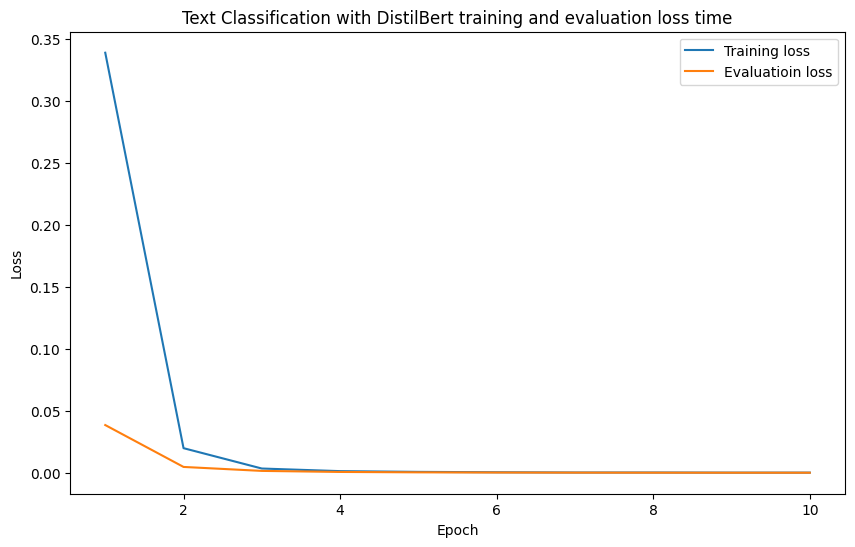

In [53]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(trainer_history_training_df['epoch'], trainer_history_training_df['loss'], label="Training loss")
plt.plot(trainer_history_eval_df['epoch'], trainer_history_eval_df['eval_loss'], label='Evaluatioin loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text Classification with DistilBert training and evaluation loss time")
plt.legend()
plt.show()

### Pushing our model to the Hugging face

In [54]:
# model_upload_url = trainer.push_to_hub(
#     commit_message="Uploading Food or Not food text classifier Model"
# )

# print(f"[INFO] Model successfully uploaded to the Hugging Face Hub with URL: {model_upload_url}")

## Making and evaluating predictions on the test data

In [55]:
# perform predictions on test data
predictions_all = trainer.predict(tokenized_dataset['test'])
predictions_values = predictions_all.predictions
predictions_metrics = predictions_all.metrics

print(f'[INFO] prediction metrics on the test data:')
predictions_metrics

[INFO] prediction metrics on the test data:


{'test_loss': 0.0005201687454245985,
 'test_accuracy': 1.0,
 'test_runtime': 0.0322,
 'test_samples_per_second': 1554.655,
 'test_steps_per_second': 62.186}

In [56]:
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities (this is optional, could get the same results with step 2 onwards)
pred_probs = torch.softmax(torch.tensor(predictions_values), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, axis=1)

# 3. Get the true labels
true_labels = dataset['test']['label']

# 4. Compare predicted labels to true labels to get the test accuracy
test_acc = accuracy_score(y_true=true_labels,
                          y_pred=pred_labels)

print(f"[INFO] Test accuracy: {test_acc*100}%")

[INFO] Test accuracy: 100.0%


In [57]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999414
1,Red brick fireplace with a mantel serving as a...,0,0,0.999602
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999421
3,Set of mugs hanging on a hook,0,0,0.999614
4,Standing floor lamp providing light next to an...,0,0,0.999607


In [58]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values('pred_prob', ascending=True).head(10)

,text,true_label,pred_label,pred_prob
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.999348
11,A close-up shot of a cheesy pizza slice being ...,1,1,0.999376
42,"Boxes of apples, pears, pineapple, manadrins a...",1,1,0.999411
14,Two handfuls of bananas in a fruit bowl with g...,1,1,0.999412
26,A fruit platter with a variety of exotic fruit...,1,1,0.999413
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999414
46,A bowl of sliced kiwi with a sprinkle of sugar...,1,1,0.999415
25,A bowl of sliced mango with a drizzle of honey...,1,1,0.999416
28,A bowl of sliced bananas with a sprinkle of co...,1,1,0.999417
9,Cherry tomatoes and mozzarella balls in a bowl...,1,1,0.999417


## Making and inspecting predictions on custom text data

In [59]:
# setup local model path
local_model_path = "models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased"

# Hugging face model path
huggingface_model_path = "shivajimallela/learn_hf_food_not_food_classifier-ditsilbert-base-uncased"

### Discussing ways to make predictions (inference)

In [60]:
def set_device():
    """
    Set device to CUDA if available, else MPS (Mac), else CPU.

    This defaults to using the best available device (usually).
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    return device

DEVICE = set_device()
print(f"Device using: {DEVICE}")

Device using: cuda


### Making predictions with pipeline

In [61]:
import torch
from transformers import pipeline

BATCH_SIZE = 32

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task='text-classification',
                                    model = local_model_path,
                                    device=DEVICE,
                                    top_k = 1,
                                    batch_size=BATCH_SIZE)

food_not_food_classifier


In [62]:
# Test our trained model on some example text 
sample_text_food = "An image of chicken biryani."

food_not_food_classifier(sample_text_food)

[[{'label': 'food', 'score': 0.9992678761482239}]]

In [63]:
# Test the model on some more example text
sample_text_not_food = "A tomato toy looks like a tomato"

food_not_food_classifier(sample_text_not_food)

[[{'label': 'food', 'score': 0.99791020154953}]]

In [64]:
# Pipeline also works with remote models (will have to laod the model locally first)
food_not_food_classifier_remote = pipeline(task='text-classification',
                                           model = huggingface_model_path,
                                           batch_size = BATCH_SIZE,
                                           device=DEVICE)

food_not_food_classifier_remote("This is some new text about bananas and pancakes and ice cream")

[{'label': 'food', 'score': 0.9993926286697388}]

### Making multiple predictions at the same time with batch prediction

In [65]:
# Create batch size (we don't need to do this again but we're doing it for clarity)
BATCH_SIZE = 32

# Setup pipeline to handle batches (we don't need to do this again either but we're doing it for clarity)
food_not_food_classifier = pipeline(task='text-classification',
                                    model = local_model_path,
                                    batch_size = BATCH_SIZE,
                                    device = DEVICE)

In [66]:
# Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[{'label': 'not_food', 'score': 0.9883651733398438},
 {'label': 'not_food', 'score': 0.9982072114944458},
 {'label': 'not_food', 'score': 0.9953621029853821},
 {'label': 'not_food', 'score': 0.9984801411628723},
 {'label': 'not_food', 'score': 0.9963819980621338},
 {'label': 'not_food', 'score': 0.9985091090202332},
 {'label': 'not_food', 'score': 0.9879025816917419},
 {'label': 'food', 'score': 0.9993512034416199},
 {'label': 'not_food', 'score': 0.999103307723999},
 {'label': 'food', 'score': 0.9848617315292358}]

### Time our model across larger sample sizes

In [67]:
import time

sentences_1000 = sentences*100

print(f"Number of sentences: {len(sentences_1000)}")

start_time_one_at_a_time = time.time()

for sentence in sentences_1000:
    food_not_food_classifier(sentence)
end_time_one_at_a_time = time.time()

print(f"Time taken for one at a time prediction: {end_time_one_at_a_time - start_time_one_at_a_time} seconds")
print(f"Avg inference time per sentence: {(end_time_one_at_a_time - start_time_one_at_a_time)/len(sentences_1000)} seconds")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Number of sentences: 1000
Time taken for one at a time prediction: 4.168275356292725 seconds
Avg inference time per sentence: 0.004168275356292724 seconds


In [68]:
for i in [10, 100, 1000, 10_000]:
    sentences_big = sentences * i
    print(f"Number of sentences: {len(sentences_big)}")

    start_time = time.time()
    # Predict on all sentences in batches 
    food_not_food_classifier(sentences_big)
    end_time = time.time()

    print(f"[INFO] Inference time for {len(sentences_big)} sentences: {round(end_time - start_time, 5)} seconds.")
    print(f"[INFO] Avg inference time per sentence: {round((end_time - start_time) / len(sentences_big), 8)} seconds.")
    print()

Number of sentences: 100
[INFO] Inference time for 100 sentences: 0.0425 seconds.
[INFO] Avg inference time per sentence: 0.00042505 seconds.

Number of sentences: 1000
[INFO] Inference time for 1000 sentences: 0.37142 seconds.
[INFO] Avg inference time per sentence: 0.00037142 seconds.

Number of sentences: 10000
[INFO] Inference time for 10000 sentences: 4.06759 seconds.
[INFO] Avg inference time per sentence: 0.00040676 seconds.

Number of sentences: 100000
[INFO] Inference time for 100000 sentences: 39.42712 seconds.
[INFO] Avg inference time per sentence: 0.00039427 seconds.



### Making predictions with PyTorch

In [69]:
from transformers import AutoTokenizer

model_path = "shivajimallela/learn_hf_food_not_food_classifier-ditsilbert-base-uncased"

sample_text_food = "A delicious photo of a plate of scrambled eggs, bacon and toast"

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)

inputs = tokenizer(sample_text_food, return_tensors='pt')

inputs

{'input_ids': tensor([[  101,  1037, 12090,  6302,  1997,  1037,  5127,  1997, 13501,  6763,
          1010, 11611,  1998, 15174,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [70]:
from transformers import AutoModelForSequenceClassification

# Load our text classification model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)

In [71]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    # outputs = model(input_ids=inputs["input_ids"],
    #                 attention_mask=inputs["attention_mask"]) # same as above, but explicitly passing in the keys
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-3.3758,  4.0070]]), hidden_states=None, attentions=None)

In [72]:
# Get predicted class and prediction probability
predicted_class_id = outputs.logits.argmax().item()
prediction_probability = torch.softmax(outputs.logits, dim=1).max().item()

print(f"Text: {sample_text_food}")
print(f"Predicted label: {model.config.id2label[predicted_class_id]}")
print(f"Prediction probability: {prediction_probability}")

Text: A delicious photo of a plate of scrambled eggs, bacon and toast
Predicted label: food
Prediction probability: 0.9993785619735718


Putting prediction code all together

In [73]:
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = 'shivajimallela/learn_hf_food_not_food_classifier-ditsilbert-base-uncased'

# load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)

# Make a sample text and tokenize it 
sample_text = "A photo of a broccoli, salmon, rice and radish dish"
inputs = tokenizer(sample_text, return_tensors='pt')

# Make a prediction
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted class and prediction probability 
output_logits = outputs.logits
predicted_class_id = torch.argmax(output_logits, dim=1).item()
predicted_class_label = model.config.id2label[predicted_class_id]
predicted_probability = torch.softmax(output_logits, dim=1).max().item()

# Print outputs
print(f"Text: {sample_text}")
print(f"Predicted class: {predicted_class_label} (prob: {predicted_probability * 100:.2f}%)")


Text: A photo of a broccoli, salmon, rice and radish dish
Predicted class: food (prob: 99.94%)


## Putting it all together

Ok, ok, we've covered a lot of ground going from dataset to trained model to making predictions on custom samples.

How about we put all of the steps we've covered so far together in a single code cell (or two)?

In [74]:
# 1. Import necessary packages

import pprint
from pathlib import Path

import numpy as np
import torch

from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 2. Setup variables for model training and saving pipeline
DATASET_NAME = "mrdbourke/learn_hf_food_not_food_image_captions"
MODEL_NAME = "distilbert/distilbert-base-uncased"
MODEL_SAVE_DIR_NAME = "models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased"

# 3. Create a directory for saving models
# Note: This will override our existing saved model (if there is one)
print(f"[INFO] Creating directory for saving model: {MODEL_SAVE_DIR_NAME}")
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents=True, exist_ok=True)

# 4. Load and preprocess the dataset from Hugging Face Hub
print(f"[INFO] Downloading dataset from Hugging Face Hub, name: {DATASET_NAME}")
dataset = datasets.load_dataset(path=DATASET_NAME)

# Create mappings from id2label and label2id (adjust these for your target dataset, can also create these programmatically)
id2label = {0: "not_food", 1:"food"}
label2id = {"not_food": 0, "food": 1}

# Create function to map IDs to labels in dataset
def map_labels_to_number(example):
    example['label'] = label2id[example['label']]
    return example

# Map preprocessing function to dataset
dataset = dataset['train'].map(map_labels_to_number)

# Split the dataset into train/test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 5. Import a tokenizer and map it to our dataset
print(f"[INFO] Tokenizing text for model training with tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                          use_fast= True)


# Create a preprocessing function to tokenize text
def tokenize_text(examples):
    return tokenizer(examples['text'],
                     padding=True, 
                     truncation=True)

tokenized_dataset = dataset.map(tokenize_text,
                                batched=True,
                                batch_size=1000)

# 6. Set up an evaluation metric & function to evaluate our model
accuracy_metric = evaluate.load('accuracy')

def compute_accuracy(predictions_and_labels):
    predictions, labels = predictions_and_labels

    if len(predictions.shape) >= 2:
        predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels)

# 7. Import a model and prepare it for training 
print(f"[INFO] Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                                           num_labels = 2,
                                                           id2label = id2label,
                                                           label2id = label2id)

print(f"[INFO] Model loading complete!")

# Setup TrainingArguments
training_args = TrainingArguments(
    output_dir= model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy='epoch',
    report_to='none',
    push_to_hub=False,
    hub_private_repo=False
)

# Create Trainer instance and train model
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

# 8. Train the model on our text dataset
print(f"[INFO] Commencing model training...")
results = trainer.train()

# 9. Save the trained model (note: this will overwrite our previous model, this is ok)
print(f"[INFO] Model training complete, saving model to local path: {model_save_dir}")
trainer.save_model(output_dir = model_save_dir)

# 10. Push the model to the Hugging Face Hub
print(f"[INFO] Uploading model to Hugging Face Hub...")
# model_upload_url = trainer.push_to_hub(
#     commit_message="Uploading food not food text classifier model"
# )

# print(f"[INFO] Model upload complete, model available at: {model_upload_url}")

# 11. Evaluate the model on the test data
print(f"[INFO] Performing evaluation on test dataset...")
predictions_all = trainer.predict(tokenized_dataset['test'])
predictions_values = predictions_all.predictions
predictions_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
pprint.pprint(predictions_metrics)

[INFO] Creating directory for saving model: models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased
[INFO] Downloading dataset from Hugging Face Hub, name: mrdbourke/learn_hf_food_not_food_image_captions
[INFO] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased


/home/spadmin/miniconda3/envs/tf217/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Loading model: distilbert/distilbert-base-uncased
[INFO] Model loading complete!
[INFO] Commencing model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.396100,0.093208,0.980000
2,0.041200,0.013922,1.000000
3,0.005200,0.002589,1.000000
4,0.002200,0.001346,1.000000
5,0.001300,0.000928,1.000000
6,0.001000,0.000745,1.000000
7,0.000800,0.000650,1.000000
8,0.000700,0.000599,1.000000
9,0.000600,0.000573,1.000000
10,0.000700,0.000564,1.000000


[INFO] Model training complete, saving model to local path: models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased
[INFO] Uploading model to Hugging Face Hub...
[INFO] Performing evaluation on test dataset...


[INFO] Prediction metrics on the test data:
{'test_accuracy': 1.0,
 'test_loss': 0.0005644088378176093,
 'test_runtime': 0.0283,
 'test_samples_per_second': 1764.893,
 'test_steps_per_second': 70.596}


Now let's make it sure works by turing it into a `transformers.pipeline` and passing it a custom sample.

In [75]:
# 12. Make sure the model works by testing it on a custom sample
food_not_food_classifier = pipeline(task='text-classification',
                                    model = model_save_dir,
                                    device=torch.device('cuda') if torch.cuda.is_available() else 'cpu',
                                    top_k=1,
                                    batch_size=32)

food_not_food_classifier("Yaay!!, We just built a food or not food classifier model.")

[[{'label': 'food', 'score': 0.9989529848098755}]]

## Turning our model into a demo

### Creating a simple function to perform inference

In [76]:
from typing import Dict

def food_not_food_classifier(text: str) -> Dict[str, float]:
    """
    Takes an input string of text and classifies it into food/not_food in the form of a dictionary.
    """
    # 2. Setup the pipeline to use the local model (or Hugging Face model path)
    food_not_food_classifier = pipeline(task='text-classification',
                                        model = local_model_path,
                                        batch_size = BATCH_SIZE,
                                        device= "cuda" if torch.cuda.is_available() else "cpu",
                                        top_k = None)
    
    # 3. Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]
    # print(food_not_food_classifier(text))

    # 4. Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item['label']] = item['score']

    return output_dict


# Test out the function
food_not_food_classifier("My lunch was chicken and salad.")

{'food': 0.99930739402771, 'not_food': 0.0006925745983608067}

### Building a small Gradio demo to run locally

In [77]:
# 1. Import Gradio as the common alias "gr"
import gradio as gr

# 2. Setup a Gradio interface to accept text and output labels
demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2),
    title='Food or Not Food Classifier',
    description="A text classifier to determine if a sentence is about food or not food.",
    examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
              ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

# 3. Launch the interface
demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Making our demo publicly accessible

In [82]:
from pathlib import Path

#Make a dir for demos
demos_dir = Path("demos")
demos_dir.mkdir(exist_ok=True)

# Create a folder for the food_not_food_text_classifer demo
food_not_food_classifier_demo_dir = Path(demos_dir, "food_not_food_text_classifier")
food_not_food_classifier_demo_dir.mkdir(exist_ok=True)

### Making an app file

In [87]:
%%writefile demos/food_not_food_text_classifier/app.py
# 1. Import the required packages
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# 2. Define function to use our model on given text 
def food_not_food_classifier(text: str) -> Dict[str, float]:
    """
    Takes an input string of text and classifies it into food/not_food in the form of a dictionary.
    """
    # 2. Setup the pipeline to use the local model (or Hugging Face model path)
    food_not_food_classifier = pipeline(task='text-classification',
                                        model = "shivajimallela/learn_hf_food_not_food_classifier-ditsilbert-base-uncased",
                                        device= "cuda" if torch.cuda.is_available() else "cpu",
                                        top_k = None)
    
    # 3. Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]
    # print(food_not_food_classifier(text))

    # 4. Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item['label']] = item['score']

    return output_dict

# 3. Create a Gradio interface with details about our app
description = """
A text classifier to determine if a sentence is about food or not food. 

Fine-tuned from [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) on a [small dataset of food and not food text](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).

See [source code](https://github.com/mrdbourke/learn-huggingface/blob/main/notebooks/hugging_face_text_classification_tutorial.ipynb).
"""

demo = gr.Interface(fn=food_not_food_classifier,
                    inputs='text',
                    outputs=gr.Label(num_top_classes=2),
                    title="😋🙅🥑 Food or Not Food Text Classifier",
                    description=description,
                    examples=[['I whipped up a fresh batch of code, but it seems to have a syntax error.'],
                    ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

# 4. Launch the interface
if __name__ == "__main__":
    demo.launch()


Overwriting demos/food_not_food_text_classifier/app.py


### Making a requirements file

In [88]:
%%writefile demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

Overwriting demos/food_not_food_text_classifier/requirements.txt


### Making a README file

In [90]:
%%writefile demos/food_not_food_text_classifier/README.md
---
title: Food Not Food Text Classifier
emoji: 😋🙅🥑
colorFrom: blue
colorTo: yellow
sdk: gradio
app_file: app.py
pinned: false
license: apache-2.0
---

# 🍗🚫🥑 Food Not Food Text Classifier

Small demo to showcase a text classifier to determine if a sentence is about food or not food.

DistillBERT model fine-tuned on a small synthetic dataset of 250 generated [Food or Not Food image captions](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).

[Source code notebook](https://github.com/mrdbourke/learn-huggingface/blob/main/notebooks/hugging_face_text_classification_tutorial.ipynb).

Writing demos/food_not_food_text_classifier/README.md


In [91]:
!ls demos/food_not_food_text_classifier/

README.md  app.py  requirements.txt


### Uploading our demo to Hugging Face Spaces

In [92]:
# 1. Import the required methods for uploading to the Hugging Face Hub
from huggingface_hub import create_repo, get_full_repo_name, upload_file, upload_folder

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "demos/food_not_food_text_classifier"
HF_TARGET_SPACE_NAME = "learn_hf_food_not_food_text_classifier_demo"
HF_REPO_TYPE = "space"
HF_SPACE_SDK = "gradio"
# HF_TOKEN = "" # OPTIONAL IF WE'VE SET IT IN ENV VARIABLE

# 3. Create a Space repository on Hugging Face Hub 
print(f"[INFO] Creating repo on Hugging Face hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    repo_type=HF_REPO_TYPE,
    private = False,
    space_sdk=HF_SPACE_SDK,
    exist_ok=True
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id= HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".",
    # token = HF_TOKEN,
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading food not food text classifier demo app.py"
)

print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

[INFO] Creating repo on Hugging Face hub with name: learn_hf_food_not_food_text_classifier_demo
[INFO] Full Hugging Face Hub repo name: shivajimallela/learn_hf_food_not_food_text_classifier_demo
[INFO] Uploading demos/food_not_food_text_classifier to repo: shivajimallela/learn_hf_food_not_food_text_classifier_demo
[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/shivajimallela/learn_hf_food_not_food_text_classifier_demo/tree/main/.


### Testing our hosted demo

In [97]:
from IPython.display import HTML


# You can get embeddable HTML code for your demo by clicking the "Embed" button on the demo page
HTML(data='''
<iframe
	src="shivajimallela/learn_hf_food_not_food_text_classifier_demo"
	frameborder="0"
	width="850"
	height="450"
></iframe>     
''')